## Housing Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading the dataset
houses = pd.read_csv("train.csv")

In [3]:
# summary of the dataset: 1460 rows, 80 columns, having some null values
print(houses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# head
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [5]:
# all numeric (float and int) variables in the dataset
houses_numeric = houses.select_dtypes(include=['float64', 'int64'])
houses_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


Here, we do not want 'ID'.

In [6]:
# dropping symboling and car_ID 
houses_numeric = houses_numeric.drop(['Id'], axis=1)
houses_numeric.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [7]:
# correlation matrix
cor = houses_numeric.corr()
cor

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


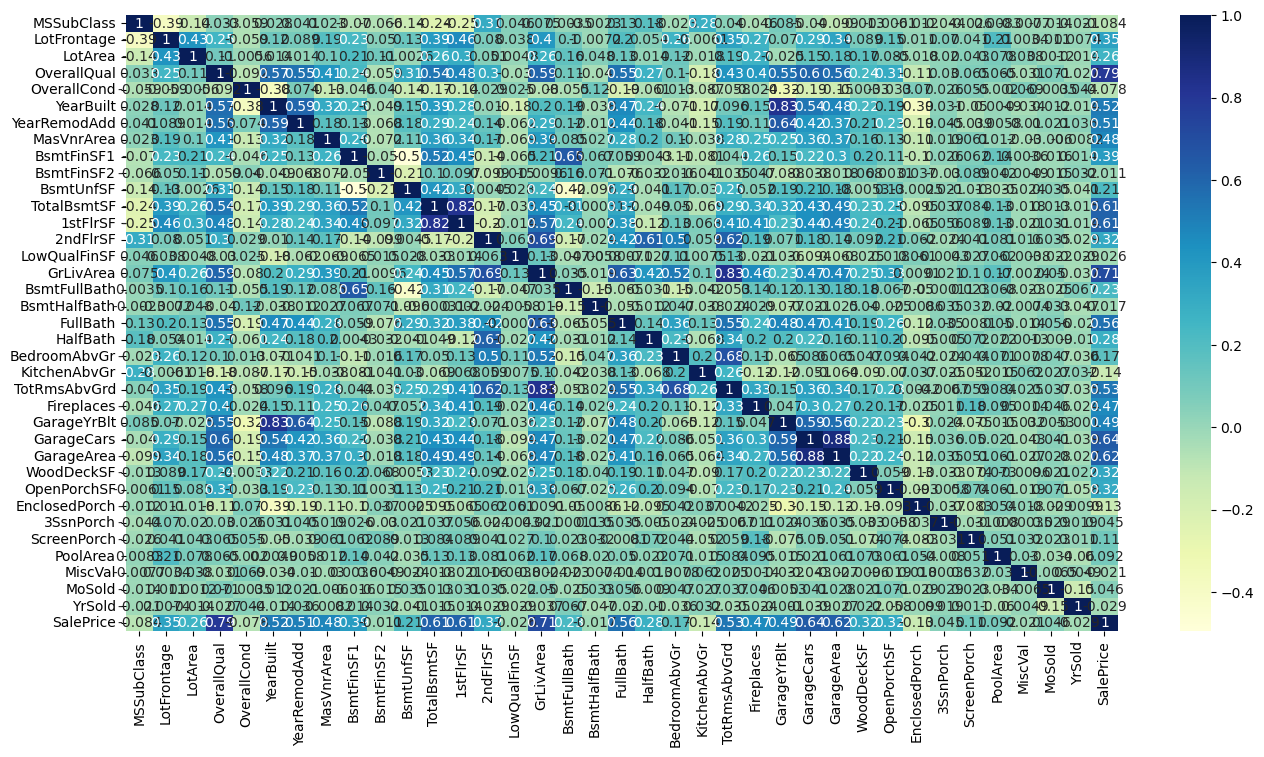

In [8]:
# plotting correlations on a heatmap
cor = houses_numeric.corr()
cor
# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


The heatmap shows some useful insights:

Correlation of price with independent variables:
- Price is highly (positively) correlated with OverallQual, TotalBsmtSF, GrliveArea, FullBath, TotRmsAbvGrd, GarageCars, GarageArea
- Price is negatively correlated to ```KitchenAbvGr``` and ```EnclosedPorch``` (-0.10 approximately).

Correlation among independent variables:
- Many independent variables are highly correlated (look at the top-left part of matrix): BarageYrBlt with YearBuilt, GrLiveArea with TotRmsAbvGrd, GarageCars with GarageArea are positively correlated 


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 


In [9]:
# variable formats
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

It can be seen from format and data dictionary, MSSubClass is categorical data with numaric value. let us convert this to object

In [10]:
# converting MSSubClass to categorical
houses['MSSubClass'] = houses['MSSubClass'].astype('object')
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
# outliers
houses.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We see many fields are having missing data. let us drop if is more than 99% and also drop the ID field, it is not requried.

In [13]:
houses = houses.drop(["Alley", "MasVnrType","FireplaceQu",  "FireplaceQu", "Fence" ,"MiscFeature","LotFrontage", "PoolQC", "Id"], axis=1)

In [14]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

Update missing numeric field value with it's mean values 

In [15]:
houses[["MasVnrArea","BsmtFinSF1",  "GarageYrBlt", "GarageCars"]] = houses[["MasVnrArea","BsmtFinSF1",  "GarageYrBlt", "GarageCars"]].fillna(houses[["MasVnrArea","BsmtFinSF1",  "GarageYrBlt", "GarageCars"]].mean())

In [16]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

Update missing categorical field value with it's mode values 

In [17]:
houses[["BsmtQual","BsmtCond",  "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", "GarageQual","GarageCond" ]] = houses[["BsmtQual","BsmtCond",  "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", "GarageQual","GarageCond" ]].fillna(houses[["BsmtQual","BsmtCond",  "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", "GarageQual","GarageCond" ]].mode())

In [18]:
houses[["Electrical"]].value_counts()

Electrical
SBrkr         1334
FuseA           94
FuseF           27
FuseP            3
Mix              1
Name: count, dtype: int64

In [19]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

We can see above now, there is no missing data

### To convert the categorical data into numaric we will use lable rather than the dummy column as there are many levels in each of the categories

In [20]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column
for column in houses.select_dtypes(include=['object']).columns.to_list():
    houses[column] = label_encoder.fit_transform(houses[column])

In [21]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int32  
 1   MSZoning       1460 non-null   int32  
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   int32  
 4   LotShape       1460 non-null   int32  
 5   LandContour    1460 non-null   int32  
 6   Utilities      1460 non-null   int32  
 7   LotConfig      1460 non-null   int32  
 8   LandSlope      1460 non-null   int32  
 9   Neighborhood   1460 non-null   int32  
 10  Condition1     1460 non-null   int32  
 11  Condition2     1460 non-null   int32  
 12  BldgType       1460 non-null   int32  
 13  HouseStyle     1460 non-null   int32  
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [22]:
type(cor)

pandas.core.frame.DataFrame

In [23]:
cor.loc["SalePrice", "MasVnrArea"]

0.47749304709571444

In [24]:
cor = houses.corr()
cor

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSSubClass,1.000000,0.037785,-0.132505,-0.025737,0.090920,-0.007658,-0.026217,0.060625,-0.029300,-0.008765,...,-0.005194,-0.044435,-0.017886,0.020837,-0.006062,0.007052,-0.022100,0.020195,-0.033097,-0.054751
MSZoning,0.037785,1.000000,-0.034452,0.087654,0.061887,-0.017854,-0.001192,-0.009895,-0.022055,-0.249679,...,0.115509,0.000362,0.019089,-0.003128,0.009293,-0.031496,-0.020628,0.097437,0.009494,-0.166872
LotArea,-0.132505,-0.034452,1.000000,-0.197131,-0.165315,-0.149083,0.010123,-0.121161,0.436868,0.044569,...,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.012292,0.034169,0.263843
Street,-0.025737,0.087654,-0.197131,1.000000,-0.010224,0.115995,0.001682,0.013960,-0.179360,-0.011561,...,0.023082,0.007473,-0.033160,0.004413,-0.022733,0.003690,-0.025043,0.014339,0.006064,0.041036
LotShape,0.090920,0.061887,-0.165315,-0.010224,1.000000,0.085434,-0.036101,0.221102,-0.099951,-0.038894,...,0.078213,-0.036459,-0.053054,-0.020051,-0.042061,-0.033455,0.036449,-0.000911,-0.038118,-0.255580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,0.007052,-0.031496,0.001205,0.003690,-0.033455,-0.011599,-0.051552,0.018902,0.007072,0.023222,...,-0.028887,0.029474,0.023217,-0.033737,-0.006495,1.000000,-0.145721,-0.047386,0.013320,0.046432
YrSold,-0.022100,-0.020628,-0.014261,-0.025043,0.036449,0.020507,0.023353,-0.005992,-0.002305,0.036697,...,-0.009916,0.018645,0.010694,-0.059689,0.004906,-0.145721,1.000000,-0.002327,0.003880,-0.028923
SaleType,0.020195,0.097437,0.012292,0.014339,-0.000911,-0.025754,-0.126770,0.014325,0.054858,-0.036956,...,-0.016731,-0.009034,0.004533,0.011009,0.015773,-0.047386,-0.002327,1.000000,0.184067,-0.054911
SaleCondition,-0.033097,0.009494,0.034169,0.006064,-0.038118,0.033809,-0.089701,0.051579,-0.043095,0.021867,...,-0.098388,0.004379,-0.020095,-0.067251,0.013027,0.013320,0.003880,0.184067,1.000000,0.213092


## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

#### Scaling the data between 0 and 1

In [25]:
cols = houses.columns
cols

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    

In [26]:
# Scaling the data between 0 and 1
scaler = MinMaxScaler()
houses[cols] = pd.DataFrame(scaler.fit_transform(houses[cols]))

In [27]:
houses.describe()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.297603,0.757192,0.043080,0.995890,0.647489,0.925799,0.000685,0.754795,0.031164,0.510474,...,0.039772,0.006712,0.031377,0.003738,0.002806,0.483811,0.453938,0.939127,0.754110,0.202779
std,0.297282,0.158004,0.046653,0.063996,0.469719,0.235889,0.026171,0.405659,0.138116,0.250572,...,0.110723,0.057711,0.116161,0.054441,0.032008,0.245784,0.332024,0.194013,0.220171,0.110321
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.750000,0.029229,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.291667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.250000,1.000000,0.800000,0.132030
50%,0.285714,0.750000,0.038227,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000,1.000000,0.800000,0.177892
75%,0.428571,0.750000,0.048150,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.708333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000,1.000000,0.800000,0.248715
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# split into X and y

y = houses.pop('SalePrice') # predictors in variable X

X = houses # response variable in Y

In [29]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Linear Regression

Let's now try predicting car prices, a dataset using linear regression.

In [30]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [31]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-0.07489156333916616
[-2.99004265e-02 -5.74281602e-03  8.13684614e-02  4.45263485e-02
 -3.60278583e-03  2.59347397e-02 -5.99235267e-02  2.05079756e-03
  3.08521054e-02  1.63518348e-02  1.43170734e-03 -9.02849634e-02
 -9.65500278e-03 -1.99126601e-02  1.53891528e-01  4.52990872e-02
  3.52100556e-02  6.75015359e-03  6.08322235e-03  5.77529359e-02
  4.60997306e-04 -1.28851652e-02  5.90601469e-02 -2.99132837e-02
  2.92281496e-03  1.51764318e-02 -5.52591700e-02  1.50042457e-02
 -2.34766443e-02 -9.58028205e-03 -1.92088550e+10  1.40153441e-02
 -5.01662868e+09 -7.95036947e+09  2.07948448e+10  4.61176276e-03
 -3.39344260e-03 -1.76493934e-03 -4.32261577e-04 -6.45490995e+10
 -3.05860235e+10 -8.47225445e+09  7.86201514e+10  4.75467139e-02
  1.16058191e-02  1.72892684e-02 -4.46156167e-03 -1.96286049e-02
 -3.58618297e-02 -3.93907734e-02  1.97260591e-02  3.54424244e-02
  2.29043739e-02  2.42317615e-03 -8.54347497e-03 -7.67485042e-04
  6.60495908e-02 -1.61784327e-02  2.11123814e-02  1.47389057e-02
 -1.

In [32]:
from sklearn.metrics import r2_score, mean_squared_error

In [33]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8432528157728207
0.8405297827501593
1.9287785625366185
0.8668515900507918
0.001889107309046639
0.0019791132192940454


## Ridge and Lasso Regression

Let's now try predicting house prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [34]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [35]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 4.0}


In [36]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 4
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-0.02541374 -0.00138666  0.02974633  0.01781209 -0.0050439   0.02107368
 -0.01011733  0.00062219  0.02908504  0.01665684  0.00206241 -0.02050538
 -0.01268874 -0.02056194  0.12159922  0.03079357  0.01516558  0.01254188
  0.01503104  0.05219504 -0.00498134 -0.0086116   0.0556066  -0.03445696
  0.00368289  0.01769637 -0.05528695  0.01374615 -0.02498943 -0.00942986
  0.02938563  0.00869119  0.01567482  0.00684144  0.03354154  0.00746293
 -0.00445836  0.00158415  0.00052009  0.08015804  0.06565317 -0.00340851
  0.09098585  0.04152553  0.00645674  0.03582028  0.00500013 -0.00250269
 -0.01685225 -0.04446007  0.04424592  0.02783732  0.03705699 -0.0038677
 -0.00511335 -0.0057301   0.04438428  0.02128487  0.0171683   0.0140064
  0.00208855  0.02141424 -0.00758933 -0.00020722  0.01290154  0.01188931
 -0.00749019 -0.00407959 -0.00274792 -0.00827625  0.00135694  0.00698279]


In [37]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8361547089195598
0.8399911066841118
2.0161209693598345
0.8697797368385022
0.0019746532510870073
0.0019857984859326535


## Lasso

In [38]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [39]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [40]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [41]:
lasso.coef_

array([-0.03326285, -0.        ,  0.02602131,  0.00476958, -0.00428125,
        0.02411099, -0.        ,  0.00124314,  0.03143747,  0.01356312,
        0.        , -0.00475328, -0.00823782, -0.01614397,  0.16149997,
        0.03346176,  0.02094782,  0.00818466,  0.00596669,  0.05477975,
       -0.        , -0.01203631,  0.05566882, -0.0270689 ,  0.00106803,
        0.01348643, -0.05664678,  0.01328262, -0.02319818, -0.01170358,
        0.        ,  0.0006599 ,  0.        , -0.00100767,  0.        ,
        0.        , -0.00408637,  0.        ,  0.        ,  0.        ,
        0.        , -0.01098739,  0.34550259,  0.04394916,  0.0015597 ,
        0.01801323,  0.        , -0.        , -0.        , -0.04037549,
        0.00430399,  0.02919787,  0.02925011, -0.00150167, -0.        ,
       -0.00291187,  0.05281262,  0.        ,  0.01681234,  0.0058524 ,
        0.        ,  0.01694037, -0.00691205, -0.        ,  0.        ,
        0.00722083, -0.        , -0.        , -0.00133135, -0.00

In [42]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8389908929278589
0.8391983119450531
1.9812216444272215
0.8740892273000361
0.0019404717379306773
0.001995637505251224


In [43]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.843253,0.836155,0.838991
1,R2 Score (Test),0.840530,0.839991,0.839198
2,RSS (Train),1.928779,2.016121,1.981222
3,RSS (Test),0.866852,0.869780,0.874089
4,MSE (Train),0.043464,0.044437,0.044051
5,MSE (Test),0.044487,0.044562,0.044673


## Lets observe the changes in the coefficients after regularization

In [44]:
betas = pd.DataFrame(index=X.columns)

In [45]:
betas.rows = X.columns

In [46]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [47]:
betas.sort_values(by=['Lasso'])

,Linear,Ridge,Lasso
BsmtQual,-5.525917e-02,-0.055287,-0.056647
KitchenQual,-3.939077e-02,-0.044460,-0.040375
MSSubClass,-2.990043e-02,-0.025414,-0.033263
ExterQual,-2.991328e-02,-0.034457,-0.027069
BsmtExposure,-2.347664e-02,-0.024989,-0.023198
...,...,...,...
GarageCars,6.604959e-02,0.044384,0.052813
RoofMatl,5.775294e-02,0.052195,0.054780
MasVnrArea,5.906015e-02,0.055607,0.055669
OverallQual,1.538915e-01,0.121599,0.161500


### Based on the above observation and result we can provide following answers:


Q1.Which variables are significant in predicting the price of a house <br>
Ans: Variables like GrLivArea, OverallQual, MasVnrArea, KitchenQual, GarageCars, BsmtQual are significant predictor of the price.


Q2:How well those variables describe the price of a house?<br>
Ans:How well variables is related can be determine by correlation value which is calucated as below:


In [48]:

print("GrLivArea with SalesPrice:"+str(cor.loc["SalePrice", "GrLivArea"]))
print("OverAllQual with SalePrice:"+str(cor.loc["SalePrice", "OverallQual"]))
print("GarageCars with SalePrice:"+str(cor.loc["SalePrice", "GarageCars"]))
print("KitchenQual with SalesPrice:"+str(cor.loc["SalePrice", "KitchenQual"]))
print("BsmtQual with SalePrice:"+str(cor.loc["SalePrice", "BsmtQual"]))


GrLivArea with SalesPrice:0.7086244776126515
OverAllQual with SalePrice:0.7909816005838053
GarageCars with SalePrice:0.6404091972583519
KitchenQual with SalesPrice:-0.589188778299423
BsmtQual with SalePrice:-0.6208861300191687



Q3:Determine the optimal value of lambda for ridge and lasso regression. <br>
Ans: Optimal value of lambda for ridge is 4 and lasso is 0.0001

Subject Question Question 3
After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   float64
 2   LotArea        1460 non-null   float64
 3   Street         1460 non-null   float64
 4   LotShape       1460 non-null   float64
 5   LandContour    1460 non-null   float64
 6   Utilities      1460 non-null   float64
 7   LotConfig      1460 non-null   float64
 8   LandSlope      1460 non-null   float64
 9   Neighborhood   1460 non-null   float64
 10  Condition1     1460 non-null   float64
 11  Condition2     1460 non-null   float64
 12  BldgType       1460 non-null   float64
 13  HouseStyle     1460 non-null   float64
 14  OverallQual    1460 non-null   float64
 15  OverallCond    1460 non-null   float64
 16  YearBuilt      1460 non-null   float64
 17  YearRemodAdd   1460 non-null   float64
 18  RoofStyl

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   float64
 2   LotArea        1460 non-null   float64
 3   Street         1460 non-null   float64
 4   LotShape       1460 non-null   float64
 5   LandContour    1460 non-null   float64
 6   Utilities      1460 non-null   float64
 7   LotConfig      1460 non-null   float64
 8   LandSlope      1460 non-null   float64
 9   Neighborhood   1460 non-null   float64
 10  Condition1     1460 non-null   float64
 11  Condition2     1460 non-null   float64
 12  BldgType       1460 non-null   float64
 13  HouseStyle     1460 non-null   float64
 14  OverallQual    1460 non-null   float64
 15  OverallCond    1460 non-null   float64
 16  YearBuilt      1460 non-null   float64
 17  YearRemodAdd   1460 non-null   float64
 18  RoofStyl

In [51]:
X.drop(['BsmtQual', 'KitchenQual', 
                'GarageCars', 'OverallQual', 'GrLivArea'], axis=1, inplace=True)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

# Printing the best hyperparameter alpha
print(model_cv.best_params_)

#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 4
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

# Printing the best hyperparameter alpha
print(model_cv.best_params_)

#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

lasso.coef_

# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

betas = pd.DataFrame(index=X.columns)

betas.rows = X.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

betas.sort_values(by=['Lasso'])





0.8117875146289214
0.8245184057923982
2.315959988533734
0.9538865725954818
0.0022683251601701604
0.00217782322510384
Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 0.6}
[-0.02596061  0.00950722  0.02492719  0.02451278 -0.00445458  0.0126736
 -0.00844669  0.00127002  0.02530923  0.02863334  0.00423233 -0.02991864
 -0.0084251  -0.02030794  0.03497359  0.03101397  0.02643987  0.02114304
  0.06226971 -0.00313384 -0.00420286  0.06988525 -0.08433286  0.00812834
  0.02574753  0.00986774 -0.03634431 -0.00699313  0.0558771   0.01219174
  0.01573394  0.02841165  0.06627362  0.00786586 -0.0077562  -0.0011987
 -0.00184676  0.11824326  0.10605649  0.00105601  0.05013225  0.01018914
  0.05440839  0.01171316 -0.02292976 -0.04154126  0.06711109  0.03409634
  0.05795205 -0.00481942  0.00140295 -0.01621985  0.07369465  0.01031525
  0.01230611  0.00241168  0.02455736 -0.00288666  0.00848608  0.01081543
  0.01856067 -0.00261019 -0.0092501  -0.00168859 -0.01020483 -0.00418188
  0.0

,Linear,Ridge,Lasso
ExterQual,-7.807301e-02,-0.084333,-0.083681
KitchenAbvGr,-9.997639e-02,-0.041541,-0.068496
Condition2,-1.394366e-01,-0.029919,-0.051833
BedroomAbvGr,-6.974428e-02,-0.022930,-0.035448
BsmtExposure,-3.367812e-02,-0.036344,-0.034784
...,...,...,...
RoofMatl,7.119985e-02,0.062270,0.066888
MasVnrArea,6.615095e-02,0.069885,0.067001
TotalBsmtSF,-7.822353e+11,0.066274,0.071673
2ndFlrSF,1.787584e-01,0.106056,0.164404


In [53]:
print("1stFlrSF with SalesPrice:"+str(cor.loc["SalePrice", "1stFlrSF"]))
print("2ndFlrSF with SalePrice:"+str(cor.loc["SalePrice", "2ndFlrSF"]))
print("TotalBsmtSF with SalePrice:"+str(cor.loc["SalePrice", "TotalBsmtSF"]))
print("ExterQual with SalePrice:"+str(cor.loc["SalePrice", "ExterQual"]))
print("KitchenAbvGr with SalesPrice:"+str(cor.loc["SalePrice", "KitchenAbvGr"]))


1stFlrSF with SalesPrice:0.6058521846919153
2ndFlrSF with SalePrice:0.31933380283206736
TotalBsmtSF with SalePrice:0.6135805515591943
ExterQual with SalePrice:-0.6368836943991116
KitchenAbvGr with SalesPrice:-0.13590737084214105
